### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 1st at 11.59pm CST
---

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import corner
import acor
import time as timer
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

In [7]:
# Read in the data to structures
data = np.load("hw5_data_1.npy")

In [8]:
#Call the different slices what they are
time = data[:,0]
measures = data[:,1]
sigma = data[:,2]

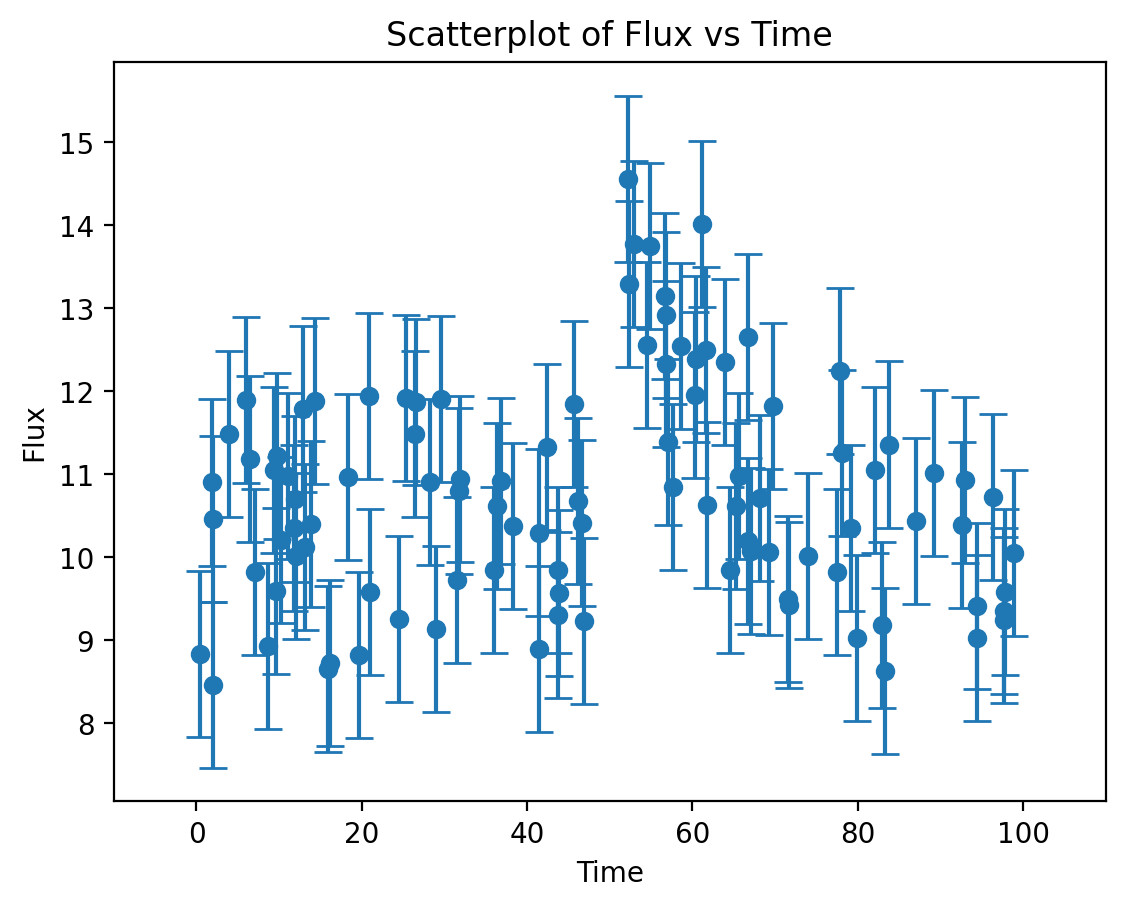

In [9]:
#Plot as a scatter plot

plt.errorbar(time,measures,fmt="o",yerr=sigma,capsize=5)
plt.xlim(-10,110)
plt.title("Scatterplot of Flux vs Time")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

In [52]:
#Copying from homework 4
#Functions to do a burst model fit, and compute the likelihood
def burst(theta, time):
    #theta[0] = b
    #theta[1] = A
    #theta[2] = t_0
    #theta[3] = alpha
    return np.where(time < theta[2],theta[0],theta[0] + theta[1] * np.exp(-theta[3]*(time-theta[2])))

# compute the data log-likelihood given a model
def logL_fast(theta, data, model=burst):
    """Gaussian log-likelihood of the model at theta"""
    time = data[:,0]
    measures = data[:,1]
    sigma = data[:,2]
    y_fit = model(theta, time)
    y = (measures - y_fit) / sigma
    return np.sum(stat.norm.logpdf(y)/sigma)

In [140]:
# Testing I did to determine vectorization of logL was correct and faster
start = timer.time()
result1 = logL([10.0,15.0,55.0,1.0],data)
end = timer.time()
print("Time elapsed logL: ",end-start)
start = timer.time()
result2 = logL_fast([10.0,15.0,55.0,1.0],data)
end = timer.time()
print("Time elapsed logL_fast: ",end-start)
print("Difference between algos:", result1-result2)
print(result1)
print(result2)

Time elapsed logL:  0.014046430587768555
Time elapsed logL_fast:  0.0006003379821777344
Difference between algos: -5.684341886080802e-14
-192.23046937715898
-192.23046937715893


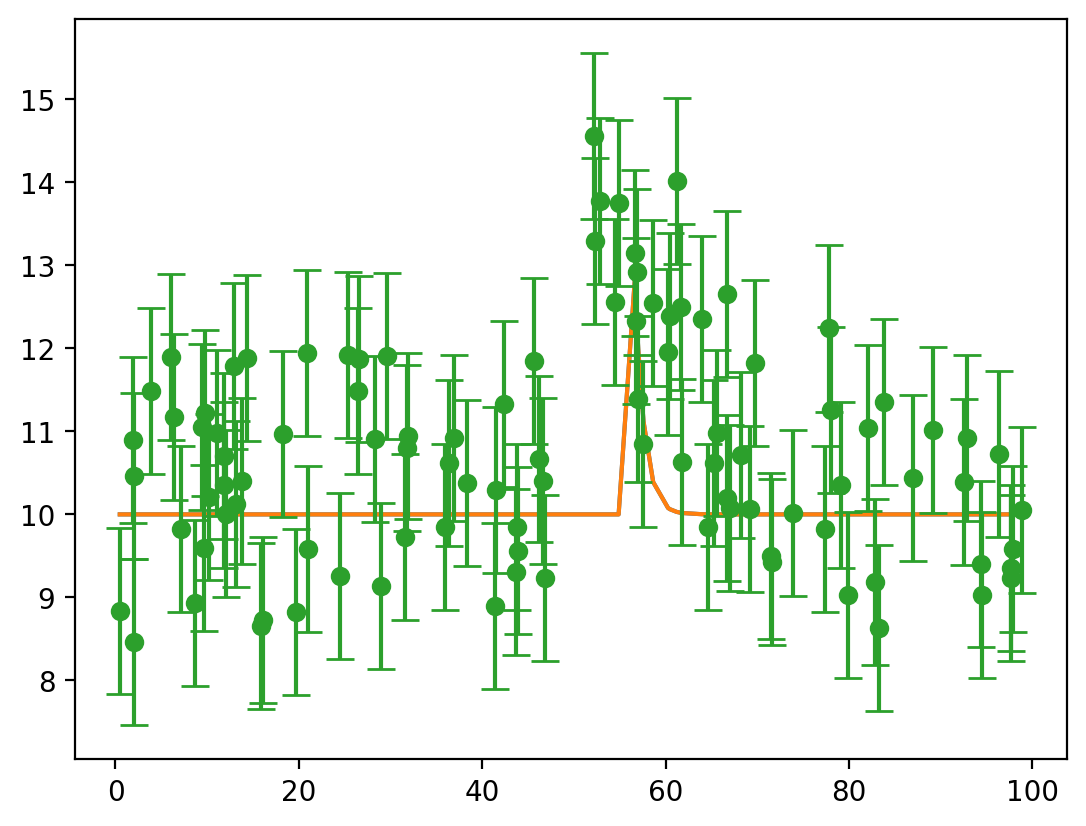

In [100]:
#Plotting to ensure decent guess of parameters led to consistant results with fast burst
plt.plot(time,burst([10.0,15.0,55.0,1.0],time))
plt.plot(time,fast_burst([10.0,15.0,55.0,1.0],time))
plt.errorbar(time,measures,fmt="o",yerr=sigma,capsize=5)
plt.show()

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

In [51]:
#Define total prior since they are all independent
def prior_b(x):
    return stat.uniform.pdf(x[0],loc=0,scale=50)

def prior_A(x):
    return stat.uniform.pdf(x[1],loc=0,scale=50)

def prior_t0(x):
    return stat.uniform.pdf(x[2],loc=0,scale=100)

def prior_lnalpha(x):
    return stat.uniform.pdf(np.log(x[3]),loc=-5,scale=10)

def log_prior(x):
    return np.log(prior_b(x) * prior_A(x) * prior_t0(x) * prior_lnalpha(x))

In [50]:
#Wrapper to call the log-likelihood function
def logL_call(theta):
    return logL_fast(theta,data)

In [144]:
#Going to utalize PTMCMCSampler
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [15]:
# dimension of parameter space
ndim = 4 #Four dimensional for b A t_0 and alpha

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

In [145]:
# intialize sampler
sampler = ptmcmc(ndim, logL_call, log_prior, cov, 
                 outDir='./my_ptmcmc_chain', resume=False)

In [149]:
# sampler for N steps (1 million)
N = int(1e6)
x0 = np.array([1.0,1.0,1.0,1.0])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.00 percent in 0.000710 s Acceptance rate = 0

/tmp/ipykernel_1474/3527294918.py:15: RuntimeWarning: divide by zero encountered in log
  return np.log(prior_b(x) * prior_A(x) * prior_t0(x) * prior_lnalpha(x))
/tmp/ipykernel_1474/3527294918.py:12: RuntimeWarning: invalid value encountered in log
  return stat.uniform.pdf(np.log(x[3]),loc=-5,scale=10)
/tmp/ipykernel_1474/4265856076.py:8: RuntimeWarning: overflow encountered in exp
  return np.where(time < theta[2],theta[0],theta[0] + theta[1] * np.exp(-theta[3]*(time-theta[2])))
/tmp/ipykernel_1474/4265856076.py:8: RuntimeWarning: overflow encountered in multiply
  return np.where(time < theta[2],theta[0],theta[0] + theta[1] * np.exp(-theta[3]*(time-theta[2])))


Adding DE jump with weight 507665 s Acceptance rate = 0.399278
Finished 100.00 percent in 693.742119 s Acceptance rate = 0.228536
Run Complete


4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [10]:
# Load in the chain
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')

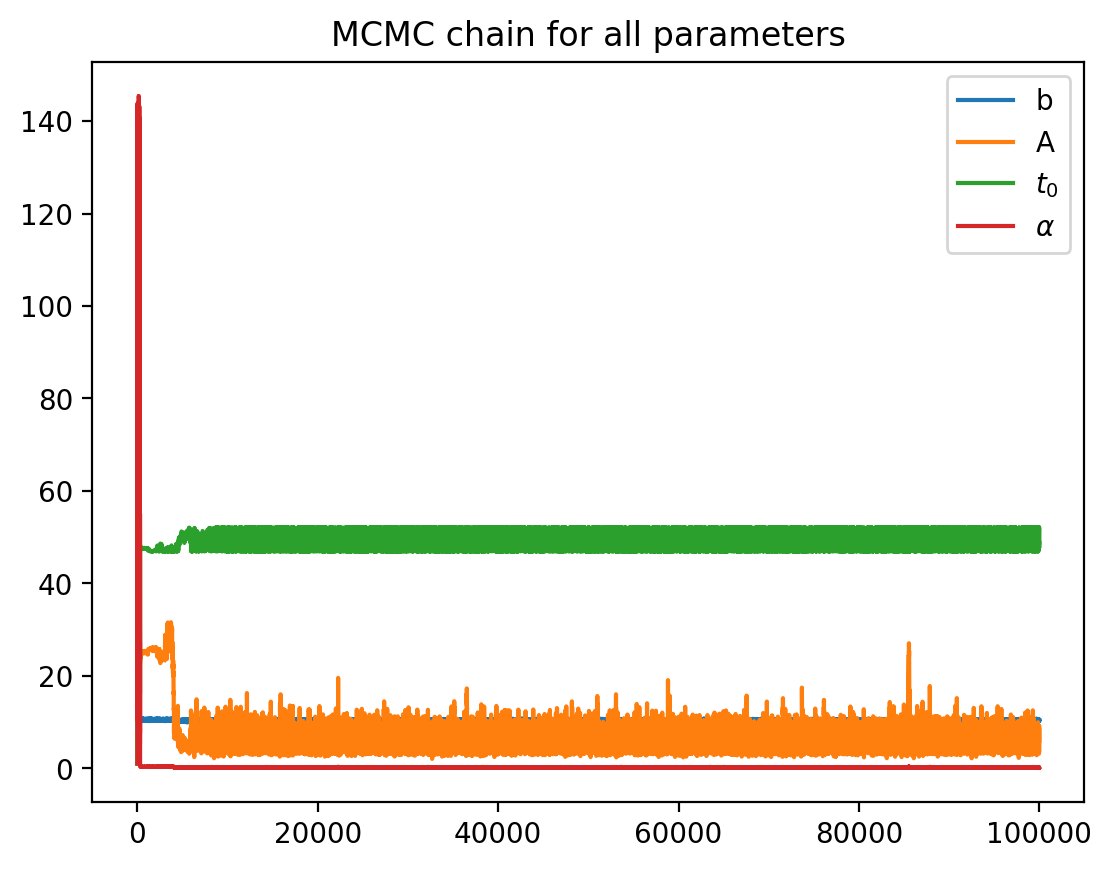

In [19]:
#Plot the chain to see the results ,,,
plt.plot(chain[:,0],label="b")
plt.plot(chain[:,1], label="A")
plt.plot(chain[:,2], label=r"$t_0$")
plt.plot(chain[:,3], label=r"$\alpha$")
plt.title("MCMC chain for all parameters")
plt.legend()
plt.show()

In [12]:
# We want to thin the chain based on when "burn in" ends
thin = 10000

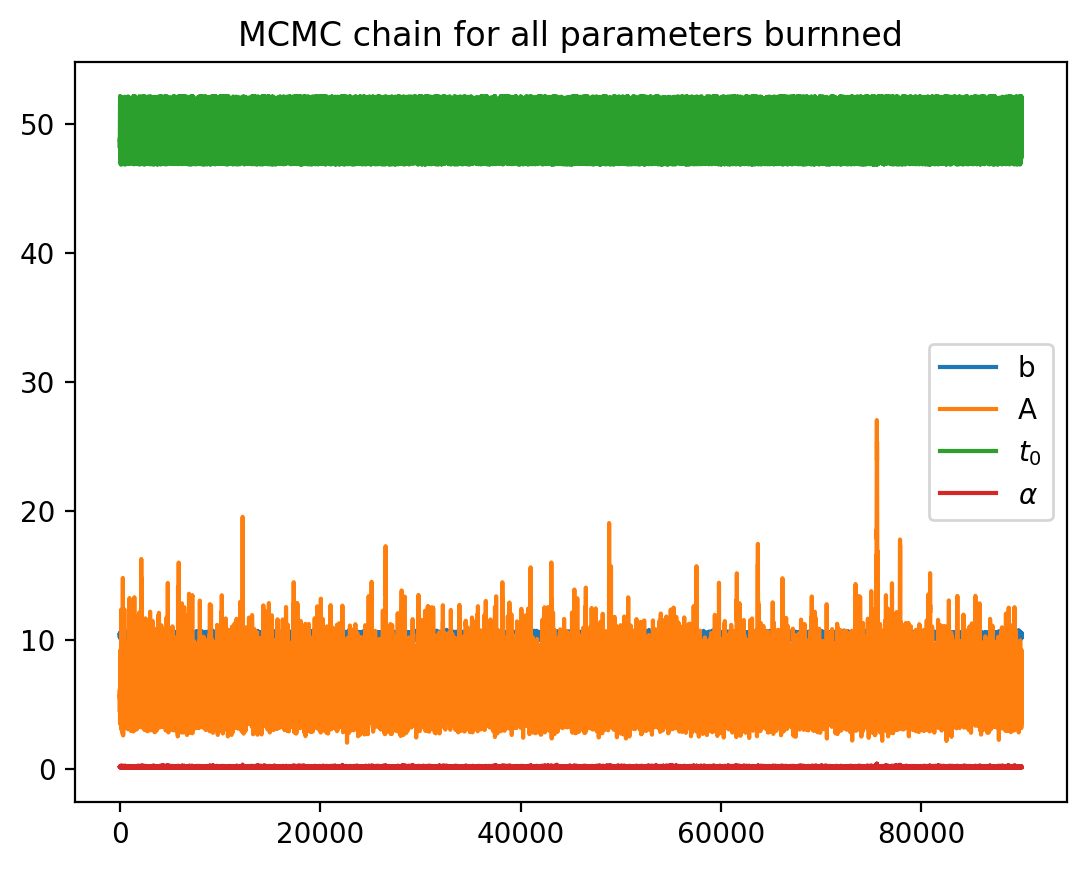

In [26]:
#Plot the chain to see the results with no burn in
plt.plot(chain[:,0][thin::],label="b")
plt.plot(chain[:,1][thin::], label="A")
plt.plot(chain[:,2][thin::], label=r"$t_0$")
plt.plot(chain[:,3][thin::], label=r"$\alpha$")
plt.title("MCMC chain for all parameters burnned")
plt.legend()
plt.show()

In [21]:
#Calculate the autocorrelation length on thinned chain
import acor
length = int(max([acor.acor(chain[:,x][thin::])[0] for x in range(ndim)])) # This searches all four parameters and finds the longest of the lengths and makes it an integer
print("Autocorrelation Length is: ", length)

Autocorrelation Length is:  15


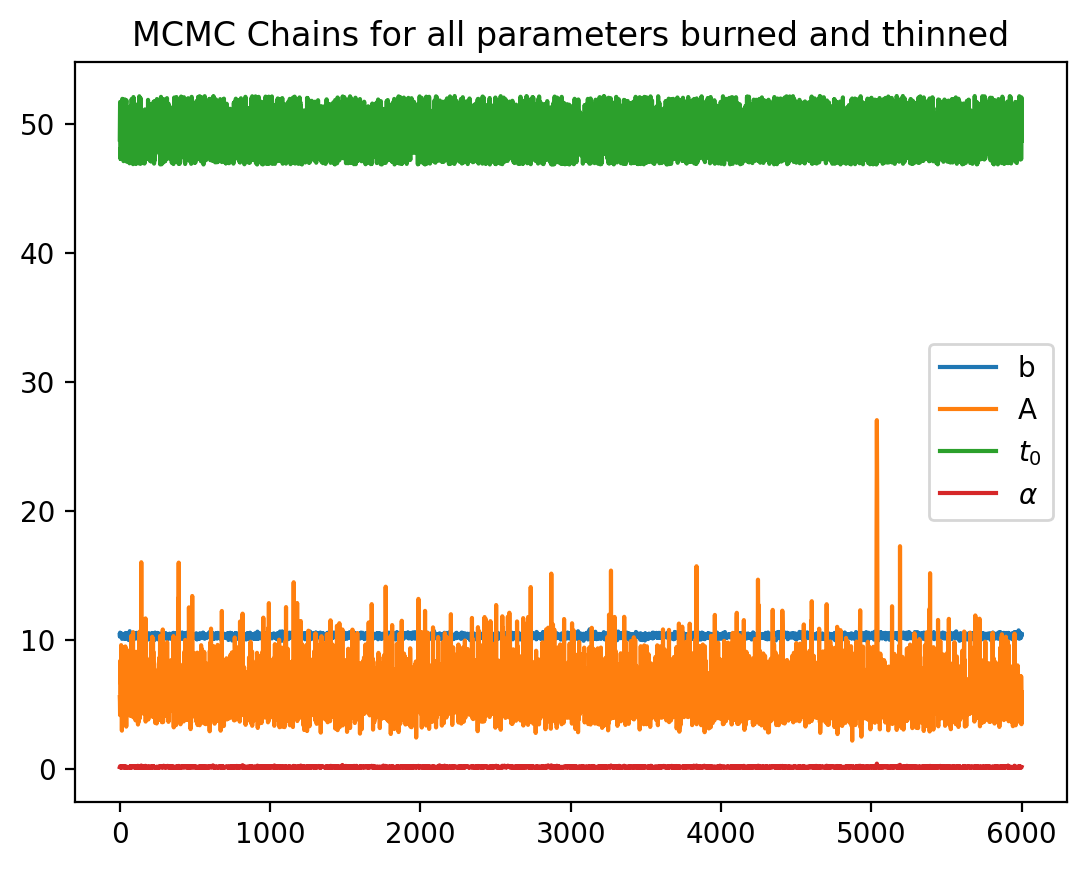

In [27]:
#Plot the chain with thin and burn in to see the results
plt.plot(chain[:,0][thin::length],label="b")
plt.plot(chain[:,1][thin::length], label="A")
plt.plot(chain[:,2][thin::length], label=r"$t_0$")
plt.plot(chain[:,3][thin::length], label=r"$\alpha$")
plt.title("MCMC Chains for all parameters burned and thinned")
plt.legend()
plt.show()

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

In [18]:
import corner

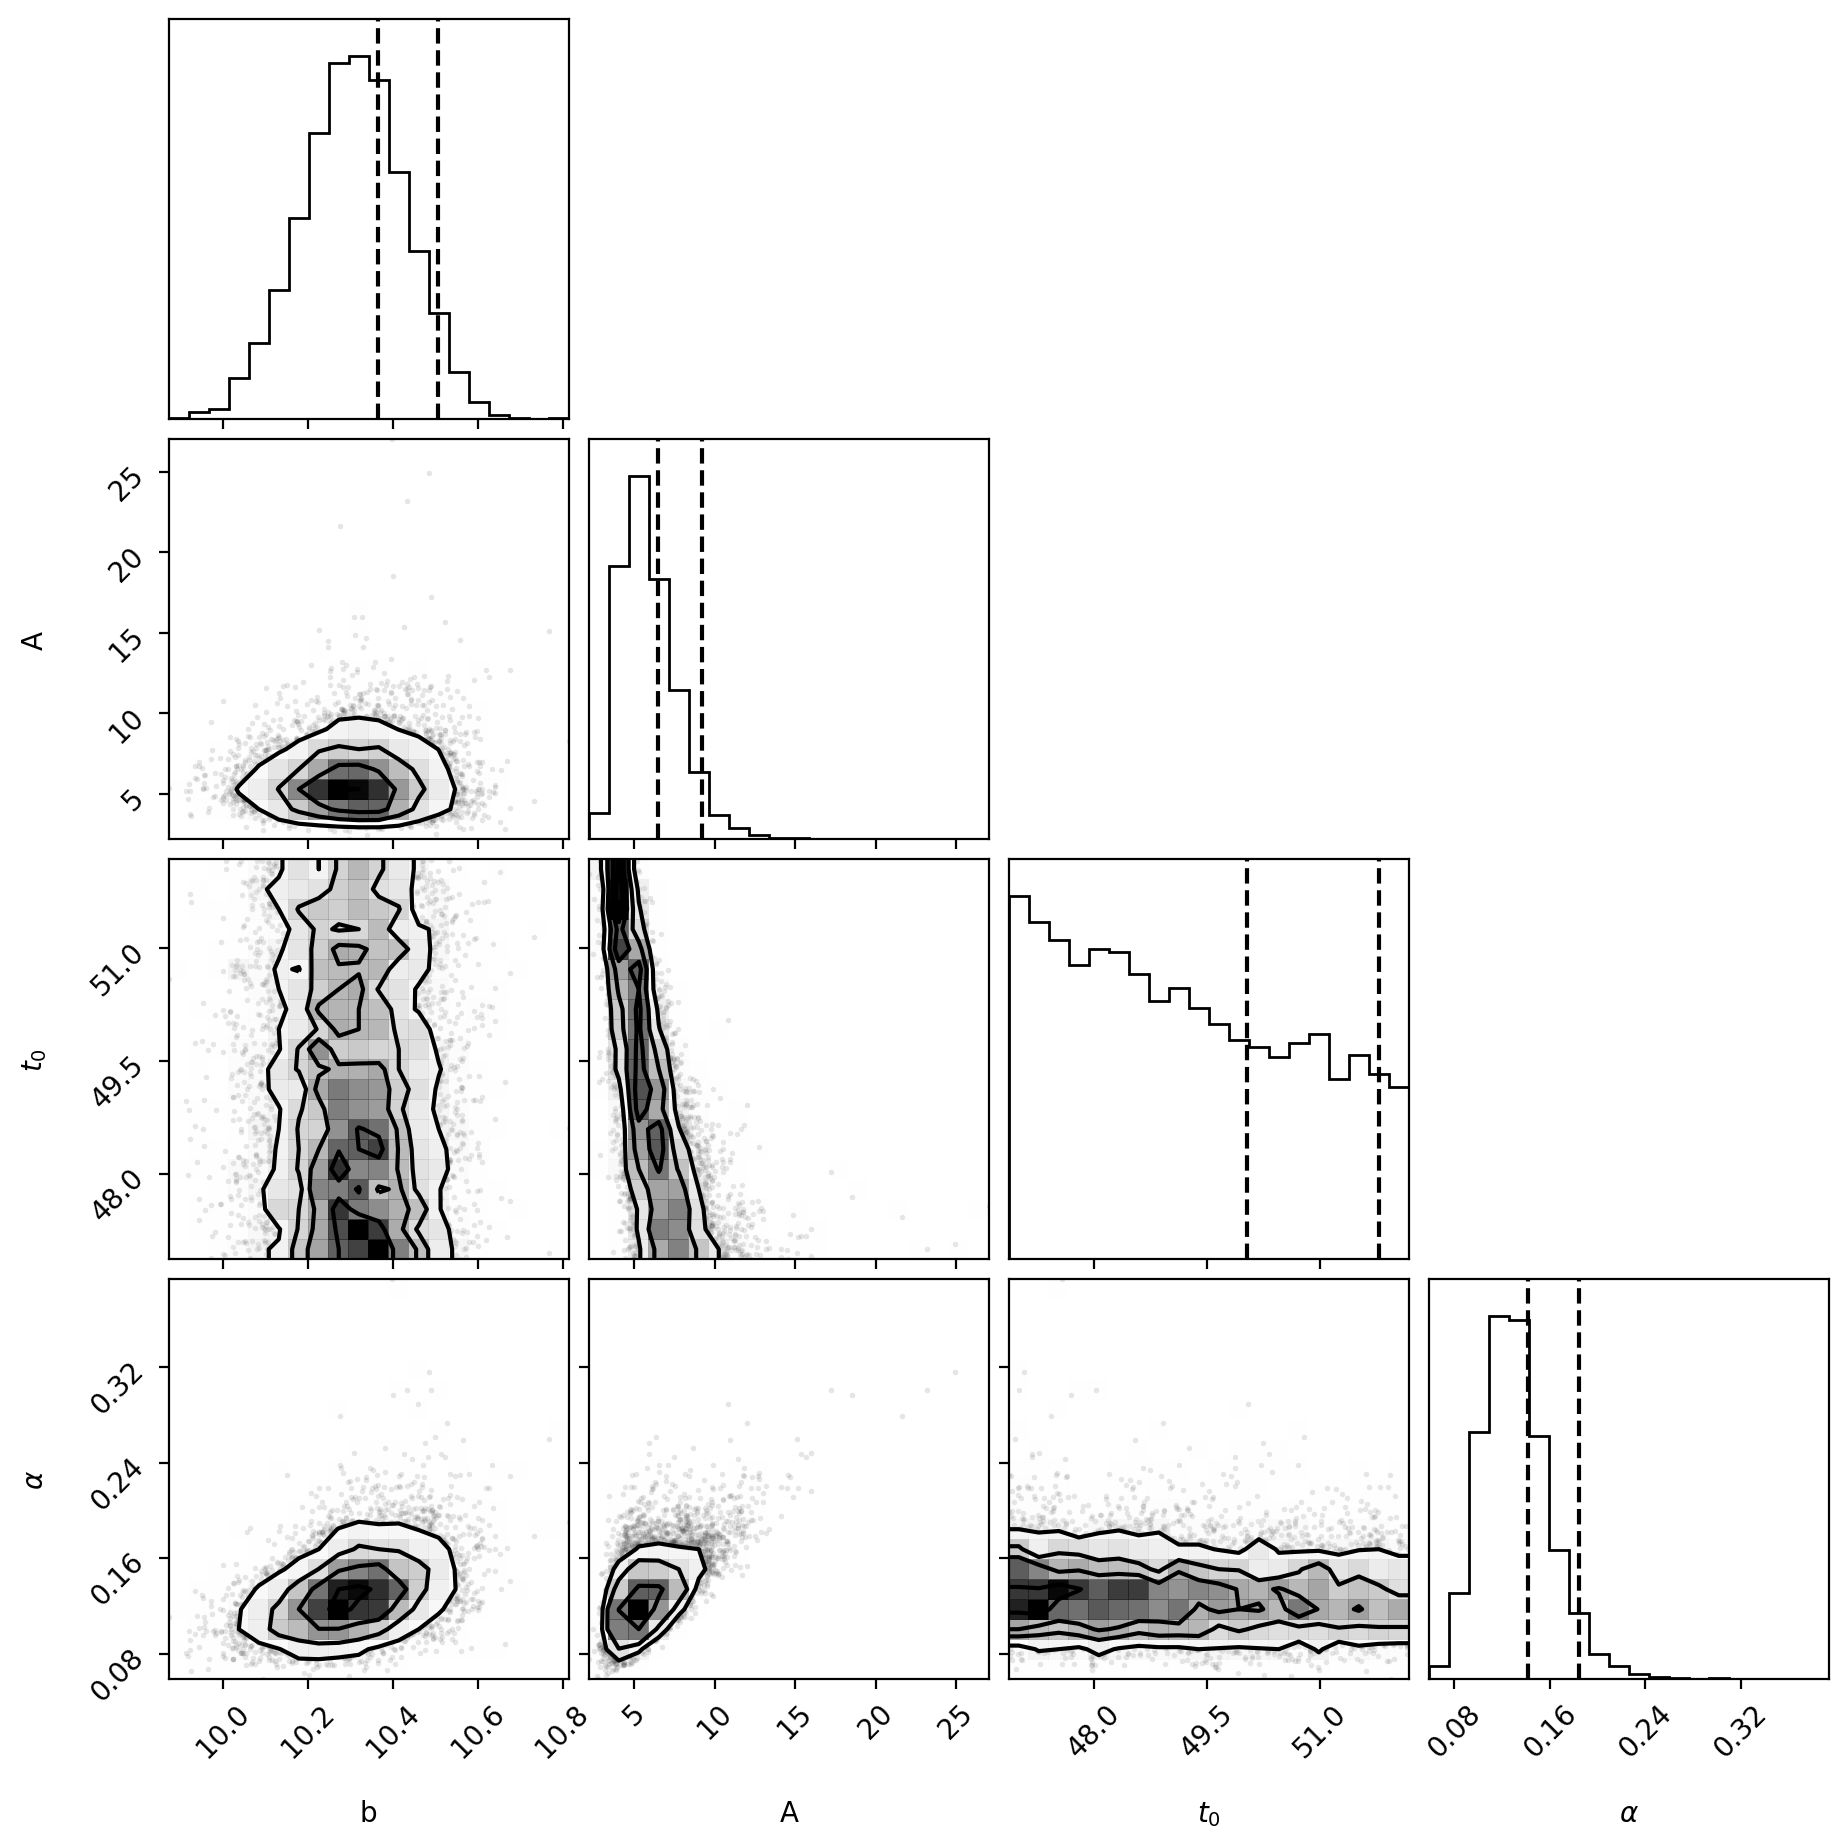

In [175]:
#Use the autocorrelation length and the burn in time to create corner plot with quantiles and parameters as titles
corner.corner(chain[:,0:4][thin::length],labels=["b","A",r"$t_0$",r"$\alpha$"],quantiles=[0.68,0.95])
plt.show()

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ same-colored burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

/tmp/ipykernel_1710/3562218707.py:8: RuntimeWarning: overflow encountered in exp
  return np.where(time < theta[2],theta[0],theta[0] + theta[1] * np.exp(-theta[3]*(time-theta[2])))


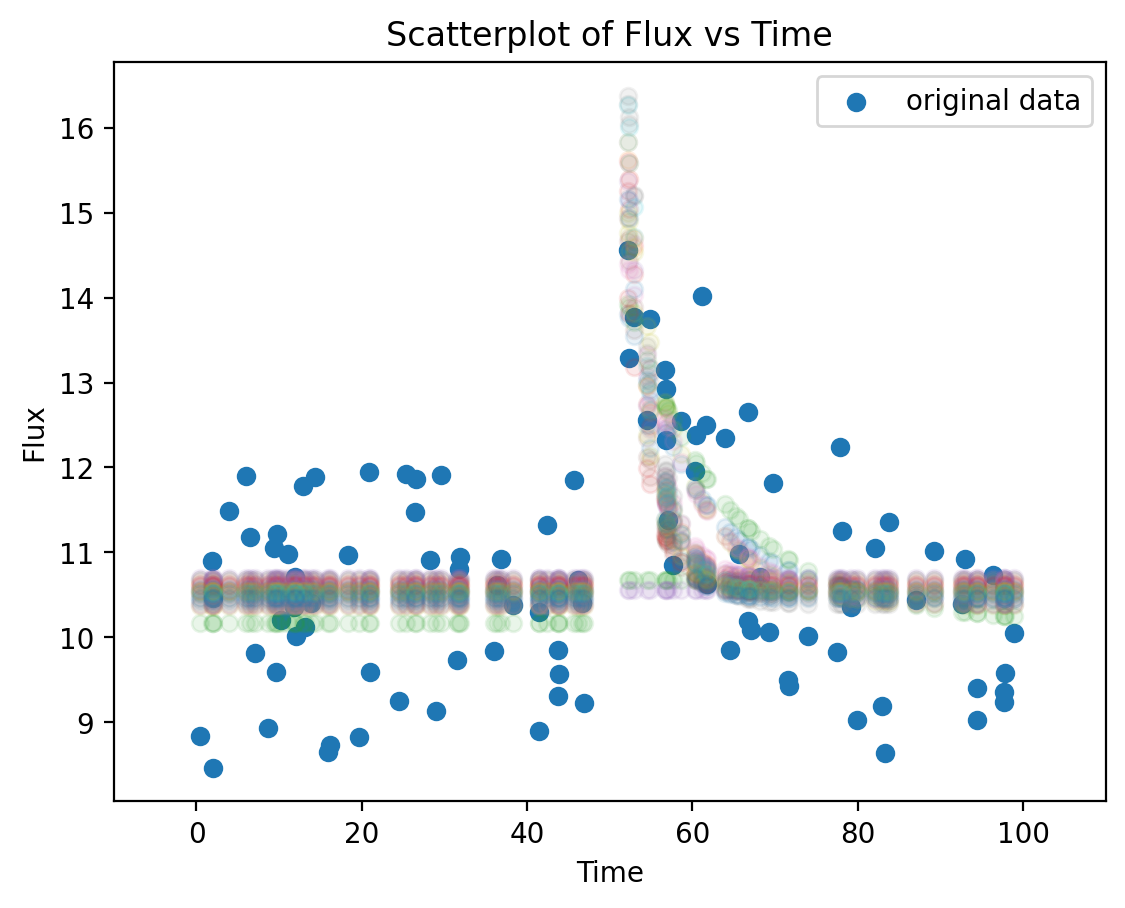

In [36]:
#Pick out possible parameters along the chain
chainSize = len(chain[:,0][thin::length])
samples = np.random.choice(range(0,chainSize),size=20,replace=False)

#Scatter the normal data
plt.scatter(time,measures,label="original data")

for sample in samples:
    params = chain[sample][0:4]
    plt.scatter(time,burst(params,time),alpha=0.1)

plt.title("100 Random Samples with Original Data")
plt.xlim(-10,110)
plt.title("Scatterplot of Flux vs Time")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

In [37]:
#Define the new model
def new_model(theta, time):
    #theta[0] = b
    #theta[1] = A
    #theta[2] = t_0
    #theta[3] = ln alpha?
    return np.where(time < theta[2],theta[0],theta[0] + theta[1] * np.exp(-theta[3]*(time-theta[2])/(2*theta[4])))

def logL_call_new(theta):
    return logL_fast(theta,data,model=new_model)

In [38]:
import dynesty

In [56]:
# Define the dimensionality of our problem.
ndim = 5

# Define our uniform priors for our 5 parameter model
def ptform_5(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""
    b = u[0] * 50. #Gives [0,50]
    A = u[1] * 50. #Gives [0,50]
    t_0 = u[2] * 100. #Gives [0,100]
    alpha = np.exp((2 ** np.log(u[3]) - 1) * 5)
    sigma_w = np.exp((2 ** np.log(u[4]) - 1) * 2)
    return np.array([b,A,t_0,alpha,sigma_w])

In [ ]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(logL_call_new, ptform_5, ndim)
sampler.run_nested()
sresults_5 = sampler.results

In [41]:
from dynesty import plotting as dyplot

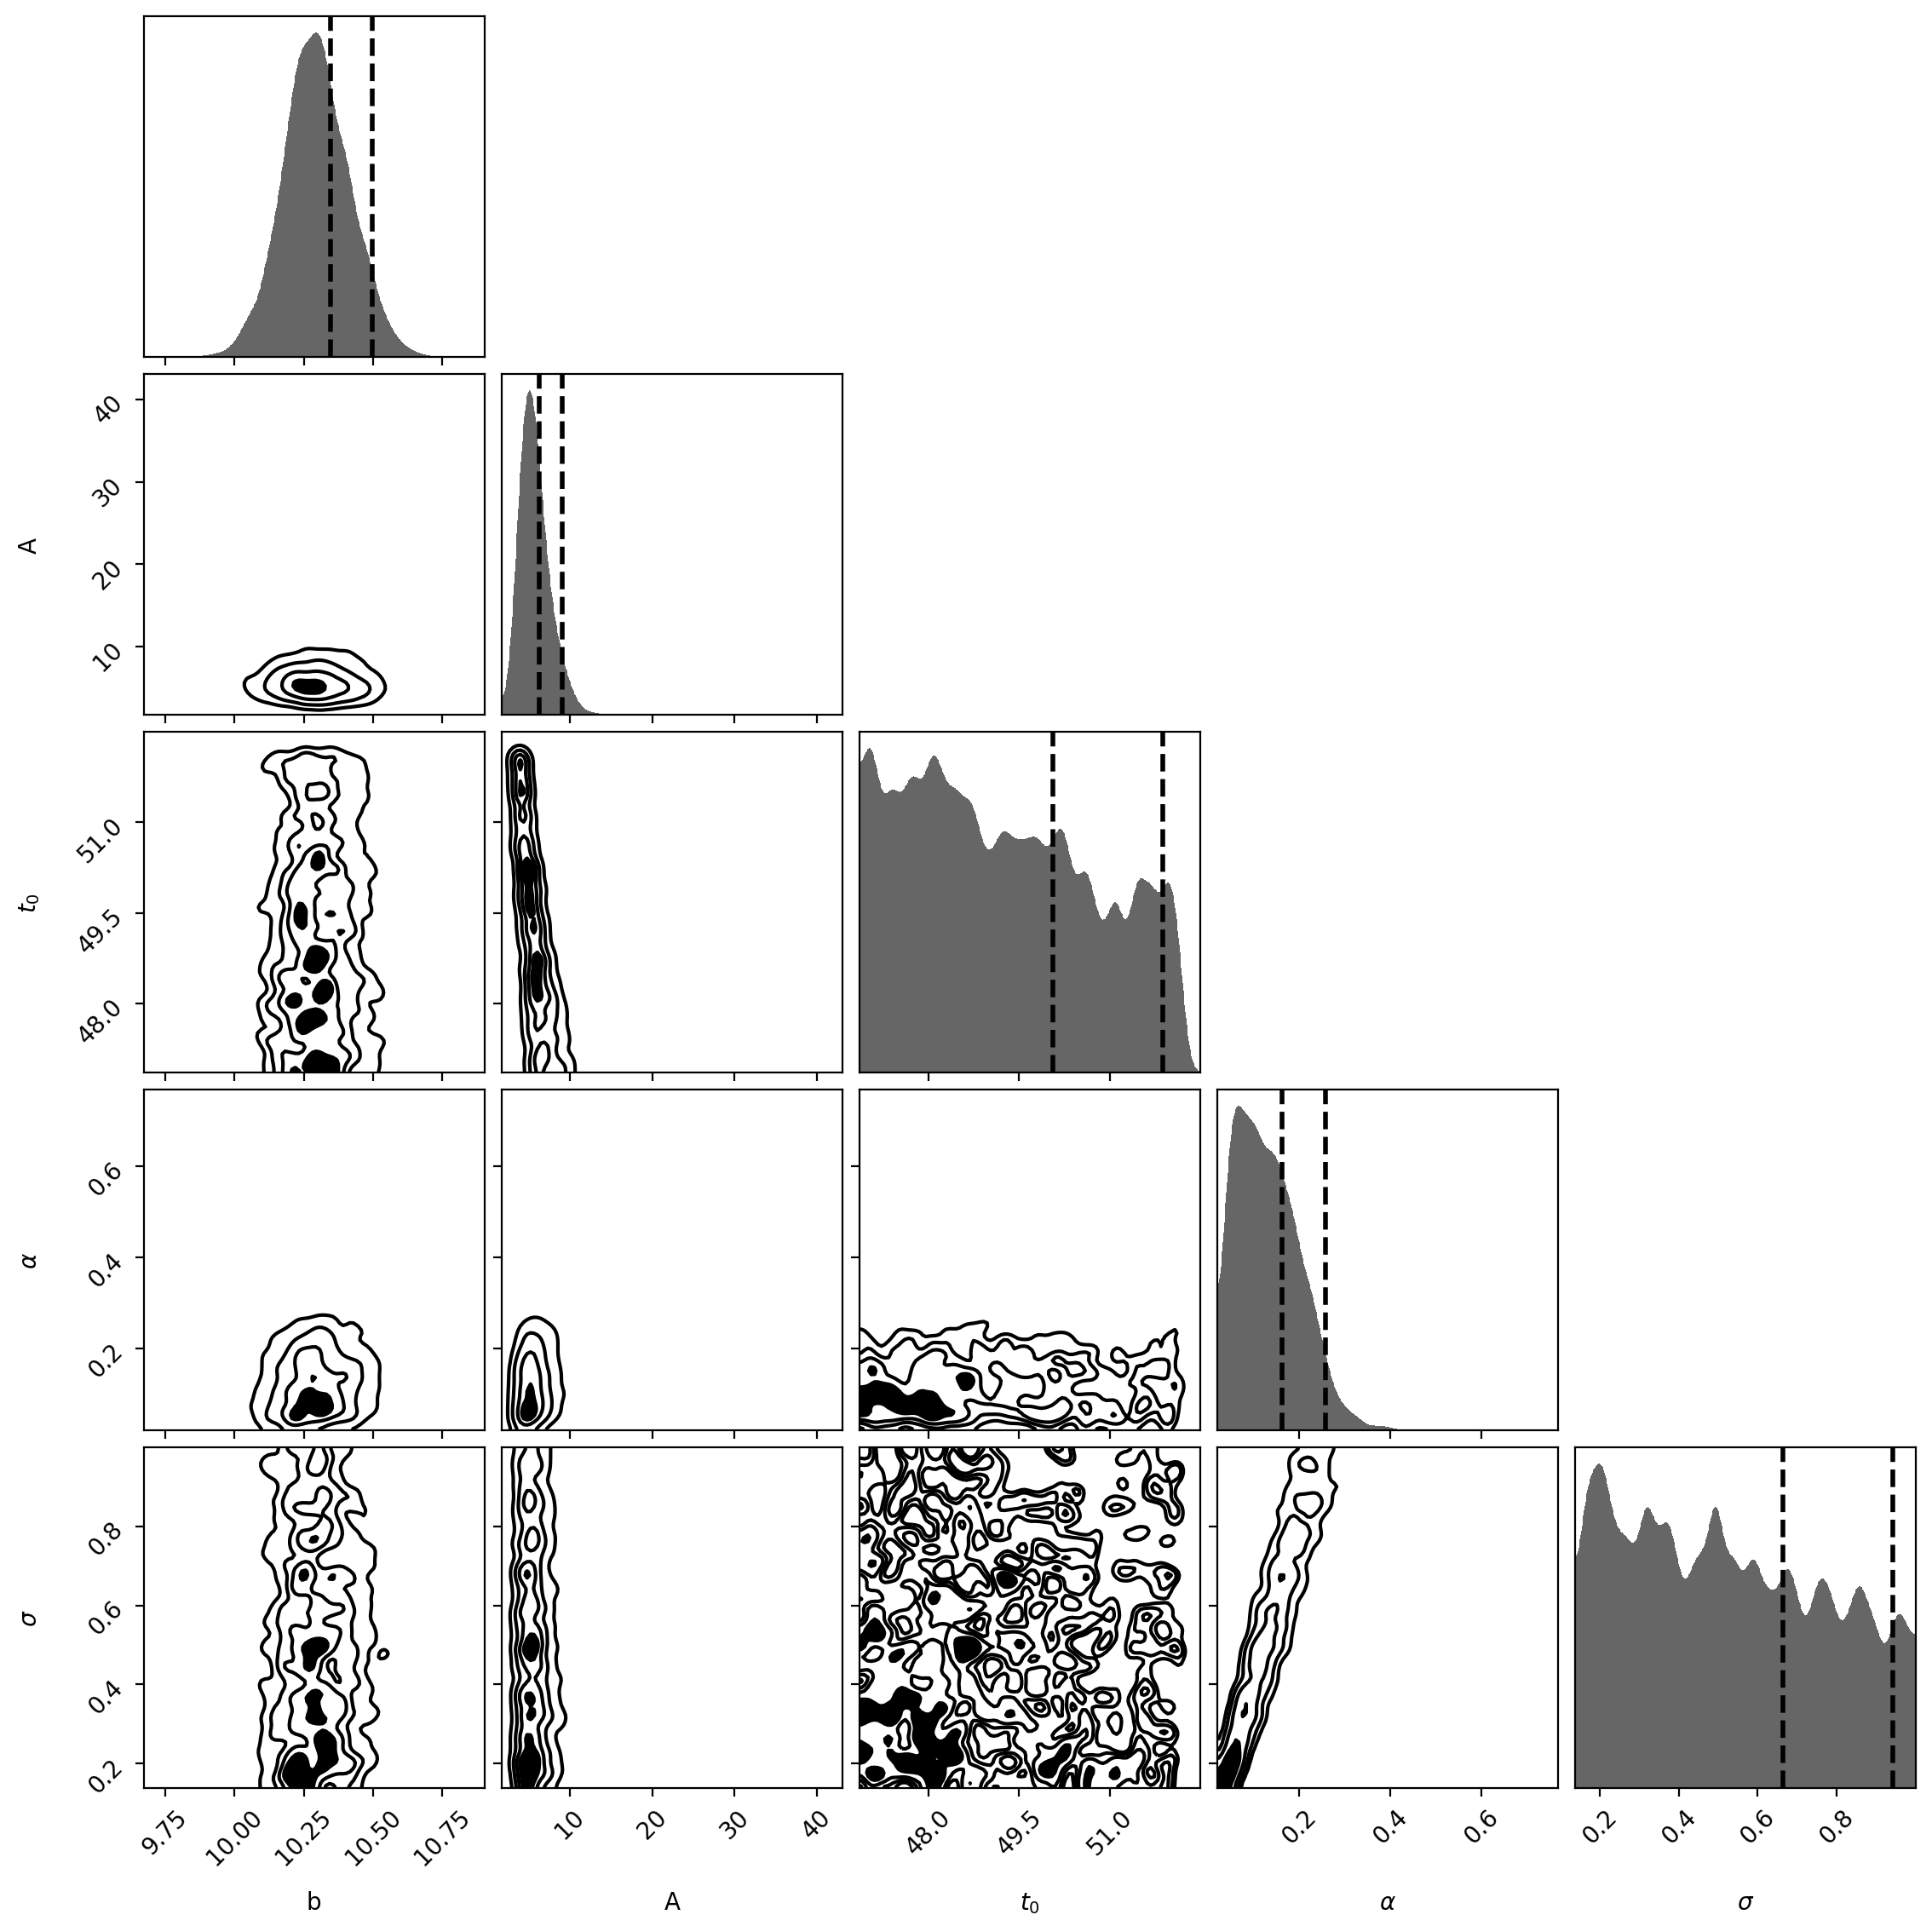

In [213]:
#Verify that the corner plots match for the parameters that we originally had
cfig, caxes = dyplot.cornerplot(sresults,labels=["b","A",r"$t_0$",r"$\alpha$",r"$\sigma$"],quantiles=[0.68,0.95])
plt.show()

In [68]:
#Get the log evidence of the 5 parameter model
evidence_5_log = sresults_5.logz[-1]

In [61]:
#Define priors for original model and run dynetsy for it
ndim = 4

# Define our uniform priors for our 4 parameter model
def ptform_4(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""
    b = u[0] * 50. #Gives [0,50]
    A = u[1] * 50. #Gives [0,50]
    t_0 = u[2] * 100. #Gives [0,100]
    alpha = np.exp((2 ** np.log(u[3]) - 1) * 5)
    return np.array([b,A,t_0,alpha])

In [ ]:
sampler = dynesty.NestedSampler(logL_call, ptform_4, ndim)
sampler.run_nested()
sresults_4 = sampler.results

In [71]:
#Get the devidence from the four parameter model
evidence_4_log = sresults_4.logz[-1]

In [72]:
#calcualte the evidence for 5 parameter model / 4parameter model
# With log evidence we do subtraction and then use that as an e exponent, this is the same as dividing the non-log evidence
print("Evidence for 5 parameters: ", evidence_5_log)
print("Evidence for 4 parameters: ", evidence_4_log)
print("Bayes Factor (5/4) : ", np.exp(evidence_5_log-evidence_4_log))

Evidence for 5 parameters:  -154.3795618211595
Evidence for 4 parameters:  -154.07934806494745
Bayes Factor (5/4) :  0.7406598831084632


<font color="blue"> A larger Z generally means that the model has more support. So in our case the Bayes factor reflects that and shows that the 5 parameter model is a slightly weaker model than 4 parameters. </font>